In [2]:
pip install luketils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 27.5 MB/s 


In [4]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=c3be90831f2019831900a70429b3ba56611ea3b884ccbd19846677a3b2ef9a22
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [98]:
import cv2

In [ ]:
import numpy as np


In [67]:
import numpy as np
import sklearn.metrics

In [70]:
import matplotlib.pyplot
import matplotlib.patches
import imageio


In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers

import keras_cv
from keras_cv import bounding_box
import os
from luketils import visualization

BATCH_SIZE = 16
EPOCHS = int(os.getenv("EPOCHS", "1"))
CHECKPOINT_PATH = os.getenv("CHECKPOINT_PATH", "checkpoint/")
INFERENCE_CHECKPOINT_PATH = os.getenv("INFERENCE_CHECKPOINT_PATH", CHECKPOINT_PATH)

**Load the PASCAL voc dataset**

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incompleteAVRECC/voc-test.tfrecord*...:   0%|          | 0/4952…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incompleteAVRECC/voc-train.tfrecord*...:   0%|          | 0/250…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incompleteAVRECC/voc-validation.tfrecord*...:   0%|          | …

Dataset voc downloaded and prepared to ~/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


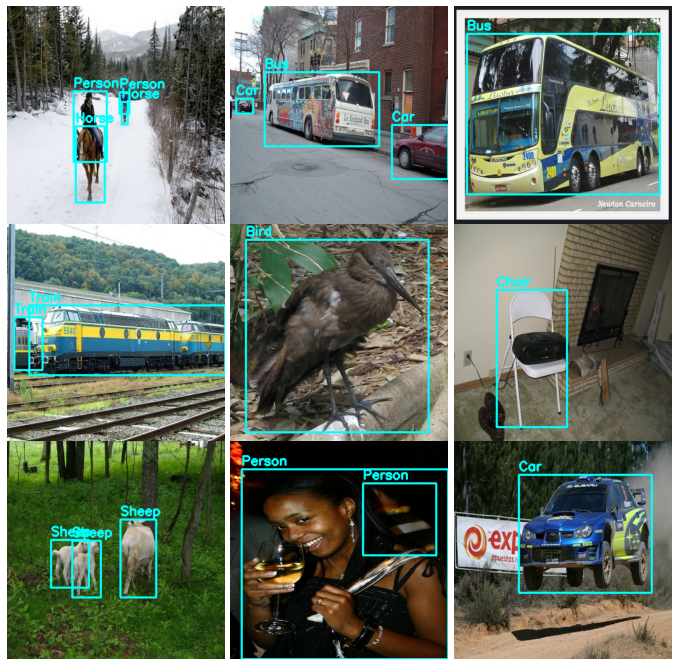

In [7]:
dataset, dataset_info = keras_cv.datasets.pascal_voc.load(
    split="train", bounding_box_format="xywh", batch_size=BATCH_SIZE
)

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))
gt= [54, 66, 198, 114];


def visualize_dataset(dataset, bounding_box_format):
    example = next(iter(dataset))
    images, boxes = example["images"], example["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=3,
        cols=3,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )


visualize_dataset(dataset, bounding_box_format="xywh")

**Split the data into testing and training**

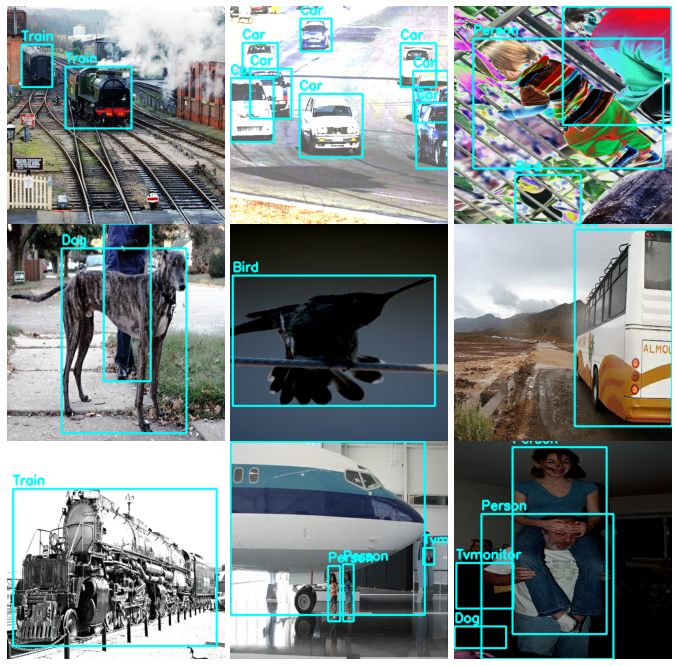

In [11]:
# train_ds is batched as a (images, bounding_boxes) tuple bounding_boxes are ragged

train_ds, train_dataset_info = keras_cv.datasets.pascal_voc.load(
    bounding_box_format="xywh", split="train", batch_size=BATCH_SIZE
)
val_ds, val_dataset_info = keras_cv.datasets.pascal_voc.load(
    bounding_box_format="xywh", split="validation", batch_size=BATCH_SIZE
)

random_flip = keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh")
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    geometric=False,
)


def augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    inputs = random_flip(inputs)
    return inputs

val_ds = val_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(train_ds, bounding_box_format="xywh")

**Dictionary making**

In [12]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

**Model**

In [13]:
model = keras_cv.models.RetinaNet(
    classes=20,
    bounding_box_format="xywh",
    backbone="resnet50",
    backbone_weights="imagenet",
    include_rescaling=True,
    evaluate_train_time_metrics=False,
)
model.backbone.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(20),
        bounding_box_format="xywh",
        name="Mean Average Precision",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

In [127]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=[
        keras_cv.metrics.COCOMeanAveragePrecision(
            class_ids=range(20),
            bounding_box_format="xywh",
            name="Mean Average Precision",
        ),
        keras_cv.metrics.COCORecall(
            class_ids=range(20),
            bounding_box_format="xywh",
            max_detections=100,
            name="Recall",
        )
    ],
)

In [16]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="logs"),
    keras.callbacks.ReduceLROnPlateau(patience=5),
    # Uncomment to train your own RetinaNet
    keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True),
]

In [17]:
model.fit(
    train_ds,
    validation_data=val_ds.take(1),
    epochs=EPOCHS,
    callbacks=callbacks,
)
model.save_weights(CHECKPOINT_PATH)

157/157 [==============================] - 8836s 56s/step - loss: 26.8427 - classification_loss: 13.9054 - regularization_loss: 0.0000e+00 - box_loss: 12.9372 - val_Mean Average Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 24.3078 - val_classification_loss: 11.3011 - val_box_loss: 13.0067 - val_regularization_loss: 0.0000e+00 - lr: 0.0100


In [18]:
model.summary()

Model: "RetinaNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 retina_net_label_encoder (R  multiple                 0         
 etinaNetLabelEncoder)                                           
                                                                 
 anchor_generator (AnchorGen  multiple                 0         
 erator)                                                         
                                                                 
 model (Functional)          [(None, None, None, 512)  23587712  
                             , (None, None, None, 102            
                             4),                                 
                              (None, None, None, 2048            
                             )]                                  
                                                                 
 nms_prediction_decoder (Nms  multiple                 0 

In [20]:
model.load_weights(INFERENCE_CHECKPOINT_PATH)
metrics = model.evaluate(val_ds.take(100), return_dict=True)
print(metrics)

100/100 [==============================] - 2710s 27s/step - Mean Average Precision: 0.0012 - Recall: 0.0034 - loss: 22.8892 - classification_loss: 11.2883 - box_loss: 11.6010 - regularization_loss: 0.0000e+00
{'Mean Average Precision': 0.0012411518255248666, 'Recall': 0.0034416615962982178, 'loss': 22.88924789428711, 'classification_loss': 11.288276672363281, 'box_loss': 11.600974082946777, 'regularization_loss': 0.0}


1/1 [==============================] - 33s 33s/step


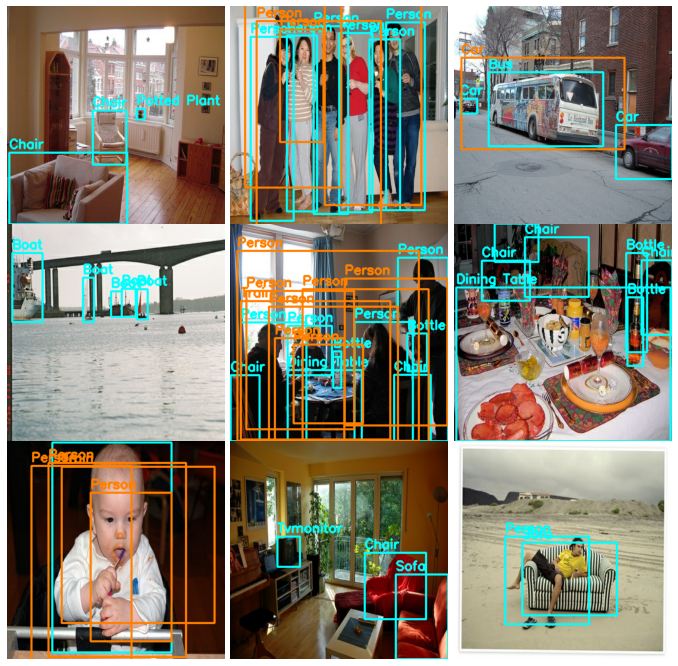

In [ ]:
def visualize_detections(model, bounding_box_format):
    train_ds, val_dataset_info = keras_cv.datasets.pascal_voc.load(
        bounding_box_format=bounding_box_format, split="test", batch_size=BATCH_SIZE
    )
    tes = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(train_ds.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=3,
        cols=3,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )


visualize_detections(model, bounding_box_format="xywh")

In [72]:
import matplotlib.pyplot
import matplotlib.patches
import imageio

def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou, intersection, union,

1/1 [==============================] - 35s 35s/step


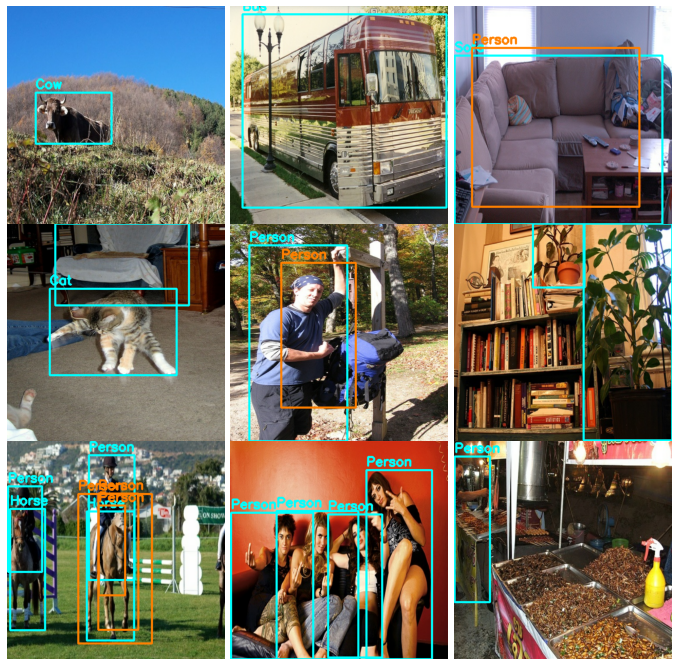

In [21]:
def visualize_detections(model, bounding_box_format):
    val_ds, val_dataset_info = keras_cv.datasets.pascal_voc.load(
        bounding_box_format=bounding_box_format, split="validation", batch_size=BATCH_SIZE
    )
    val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(val_ds.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=3,
        cols=3,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )

visualize_detections(model, bounding_box_format="xywh")

**Prediction Results**

0.7997097242380261 55100 68900


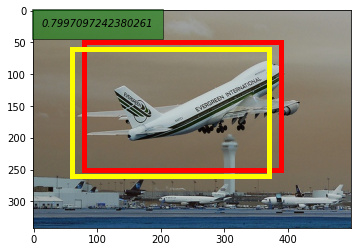

In [121]:
im = cv2.imread("2007_001288.jpg")

pred_box = [60, 60, 310, 200]
gt_box = [80, 50, 310, 200]

iou, intersect, union = intersection_over_union(gt_box, pred_box)
print(iou, intersect, union)

fig, ax = matplotlib.pyplot.subplots(1)
ax.imshow(im)

gt_rect = matplotlib.patches.Rectangle((gt_box[0], gt_box[1]),
                                       gt_box[2],
                                       gt_box[3],
                                       linewidth=5,
                                       edgecolor='r',
                                       facecolor='none')

pred_rect = matplotlib.patches.Rectangle((pred_box[0], pred_box[1]),
                                         pred_box[2],
                                         pred_box[3],
                                         linewidth=5,
                                         edgecolor=(1, 1, 0),
                                         facecolor='none')
#text.color: blue
ax.text(13, 25, iou, style='italic', bbox={
        'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
ax.add_patch(gt_rect)
ax.add_patch(pred_rect)